# Revolutionizing Football Analysis: A Deep Learning Approch to Predict the direction of Penalty in Football

The main aim of this project is to predict the direction of penalty shot in Football using pre-trained Deep Learning models and Image frames just before penalty shot has been taken. In this notebook InceptionV3 pre-trained deep learning model has been utilized. The images that are used for training the model has been taken out from penalty shoot videos. The images are classified into 5 categories based on the direction of the shot. The classes are Centre, Left_lower, Left_upper, Right_lower, Right_upper.

In this notebook step by step implementation of this project has been depicted.

In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### The necessary Python library has been imported

In [2]:
%%capture
import cv2
import numpy as np
import PIL.Image as Image
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Importing the Image Dataset

In [3]:
data = '/kaggle/input/planet-detect/Planet_detect'
data = pathlib.Path(data)
data

PosixPath('/kaggle/input/planet-detect/Planet_detect')

### Counting total number of images

In [4]:
image_count = len(list(data.glob('*/*.png')))
print(image_count)

2960


### Some sample Images used for this project

In [5]:
exo = list(data.glob('exo_zip/*'))
non_exo = list(data.glob('non_exo_zip/*'))

In [6]:
print(len(exo))
print(len(non_exo))

1480
1480


In [7]:
import random

exo = random.sample(exo, 500)
non_exo = random.sample(non_exo, 500)
print(len(exo))
print(len(non_exo))

500
500


### Creating a dictionary data structure for storing penalty shot images based on its direction

In [8]:
image_dict = {
    'exo': exo,
    'non_exo': non_exo
}

### Plotting Distribution of Image dataset based on Penalty shot direction

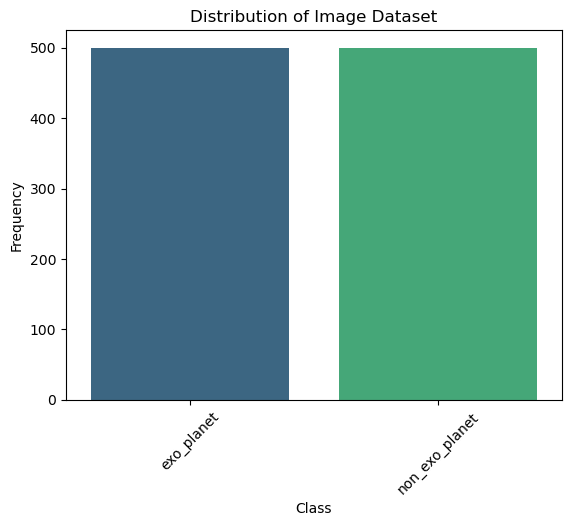

In [9]:
import pandas as pd
a = len(image_dict['exo'])
b = len(image_dict['non_exo'])


data = {
    'Class':['exo_planet','non_exo_planet'],
    'freq':[a,b]
}

df = pd.DataFrame(data)
# Choose a colormap for the plot
colors = sns.color_palette("viridis", n_colors=len(df))

# Plotting a horizontal bar plot with seaborn
ax = sns.barplot(x='Class', y='freq', data=df, palette=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Distribution of Image Dataset')
plt.show()

### Labeling the Class(Penalty shot direction) 

In [10]:
labels_dict = {
    'exo':0,
    'non_exo':1
}

### Printing the Shape of the Images used

In [11]:
img = cv2.imread(str(image_dict['exo'][0]))

print(img.shape)

(462, 775, 3)


### Storing the images and its corresponding labels in array data structure

In [34]:
X, y = [], []

for cl, images in image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(labels_dict[cl])
        
X = np.array(X)
y = np.array(y)   

### The Class labels has been One-hot-encoded

In [35]:
# Convert to one-hot encoding
num_classes = np.max(y) + 1  # Assuming class labels start from 0
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

### Splitting the Dataset into Train and Test Dataset

In [36]:
from sklearn.model_selection import train_test_split
# Define the split ratios
train_ratio = 0.85
test_ratio = 0.15
#validate_ratio = 0.15

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=1 - train_ratio, random_state=42)
#X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=validate_ratio / (test_ratio + validate_ratio), random_state=42)

# Verify the sizes of the sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
#print("Validation set size:", len(X_validate))'''

Train set size: 849
Test set size: 151


### Loading the Pre-trained Deep Learning Model(InceptionV3) 

In [15]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [16]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

### Plotting the Feature Map of the InceptionV3 Pre-trained Model

In [ ]:
# Access the layers attribute to get a list of layer objects
layers = base_model.layers

# Create a list to store the names of the layers
layer_names = []

# Iterate through the layers and append their names to the list
for layer in layers:
    layer_names.append(layer.name)

In [ ]:
from tensorflow.keras.preprocessing import image
# Load and preprocess an example image
img_path = '/kaggle/input/dog-sentiment/Dog Images/Happy dog/10.jpg'   # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array/255
img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)

# Get the feature maps from all layers
#layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]  # Selecting Conv2D layers
outputs = [base_model.get_layer(name).output for name in layer_names]
feature_extraction_model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)


# Get the feature maps for the input image
feature_maps = feature_extraction_model(img_array)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title('Original Image')
plt.show()

# Display one feature map for first layer
for i, feature_map in enumerate(feature_maps):
    if i==310:
        plt.figure(figsize=(8, 8))
        plt.imshow(feature_map[0, :, :, 0], cmap='viridis')  # Display the first channel of the feature map
        plt.axis('off')
        plt.title(f'Feature Map - Layer {layer_names[i]}')
        #plt.show()
        plt.savefig('temp_plot.jpeg')  
        temp_plot = Image.open('temp_plot.jpeg')
        temp_plot.save('feature_map.jpeg')
        temp_plot.close()  
        os.remove('feature_map.jpeg')

# Display one feature map for last layer
'''for i, feature_map in enumerate(feature_maps):
    if i==310:
        plt.figure(figsize=(8, 8))
        plt.imshow(feature_map[0, :, :, 0], cmap='viridis')  # Display the first channel of the feature map
        plt.axis('off')
        plt.title(f'Feature Map - Layer {layer_names[i]}')
        #plt.show()
        plt.savefig('temp_plot.jpeg')  
        temp_plot = Image.open('temp_plot.jpeg')
        temp_plot.save('feature_map_1.jpeg')
        temp_plot.close()  
        os.remove('feature_map_1.jpeg')    ''' 
        

### The feature extractor converts each (224 * 224 * 3) image into a (5 * 5 * 2048) block of features

In [17]:
feature_batch = base_model(X_train)
print(feature_batch.shape)

(849, 5, 5, 2048)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),  
  tf.keras.layers.RandomRotation(0.1),
])

### Freeze the Convolutional Base
It is important to freeze the convolutional base before compilation and training the pre-trained deep learning models. It is done so that while training the weights in a given layer do not get updated.

In [18]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
#base_model.summary()

### Number of layers in the model used:

In [19]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


## Adding a classification head to the model

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(849, 2048)


In [21]:
prediction_layer = tf.keras.layers.Dense(2,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(849, 2)


In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = tf.image.central_crop(x, central_fraction=0.5)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Plotting the image of the Deep Learning Model used:

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compiling the Deep Learning Model:

In [23]:
base_learning_rate = 0.0001  # Set your desired learning rate
num_classes = 2  # Set the number of classes in your problem

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='binary_crossentropy',
    metrics=['acc','Precision','Recall',
            tf.keras.metrics.AUC(multi_label=True),
             tf.keras.metrics.FalsePositives(name='fp'),
             tf.keras.metrics.FalseNegatives(name='fn'), 
             tf.keras.metrics.TruePositives(name='tp'), 
             tf.keras.metrics.TrueNegatives(name='tn')
            ]
)

### Summary of the Deep Learning Model

In [ ]:
model.summary()

In [ ]:
#len(model.trainable_variables)

### Training the Model
Remove '%%capture' from beginning of the code to see the epochs running

In [24]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_acc", 
        patience=40,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(X_train, y_train,batch_size =32, epochs=200,callbacks=[early_stop], validation_data=(X_test,y_test))

#model.save('trained_model_4.h5')

Epoch 1/200
27/27 [==============================] - 13s 201ms/step - loss: 0.7424 - acc: 0.5241 - precision: 0.5095 - recall: 0.5677 - auc: 0.5198 - fp: 464.0000 - fn: 367.0000 - tp: 482.0000 - tn: 385.0000 - val_loss: 0.7038 - val_acc: 0.5166 - val_precision: 0.5285 - val_recall: 0.4305 - val_auc: 0.5507 - val_fp: 58.0000 - val_fn: 86.0000 - val_tp: 65.0000 - val_tn: 93.0000
Epoch 2/200
27/27 [==============================] - 2s 59ms/step - loss: 0.7156 - acc: 0.5689 - precision: 0.5362 - recall: 0.5065 - auc: 0.5494 - fp: 372.0000 - fn: 419.0000 - tp: 430.0000 - tn: 477.0000 - val_loss: 0.6646 - val_acc: 0.6755 - val_precision: 0.5850 - val_recall: 0.5695 - val_auc: 0.6336 - val_fp: 61.0000 - val_fn: 65.0000 - val_tp: 86.0000 - val_tn: 90.0000
Epoch 3/200
27/27 [==============================] - 2s 61ms/step - loss: 0.6839 - acc: 0.6278 - precision: 0.5695 - recall: 0.5842 - auc: 0.6049 - fp: 375.0000 - fn: 353.0000 - tp: 496.0000 - tn: 474.0000 - val_loss: 0.6343 - val_acc: 0.7285

### Plotting Accuracy vs epochs and Loss vs epochs graphs

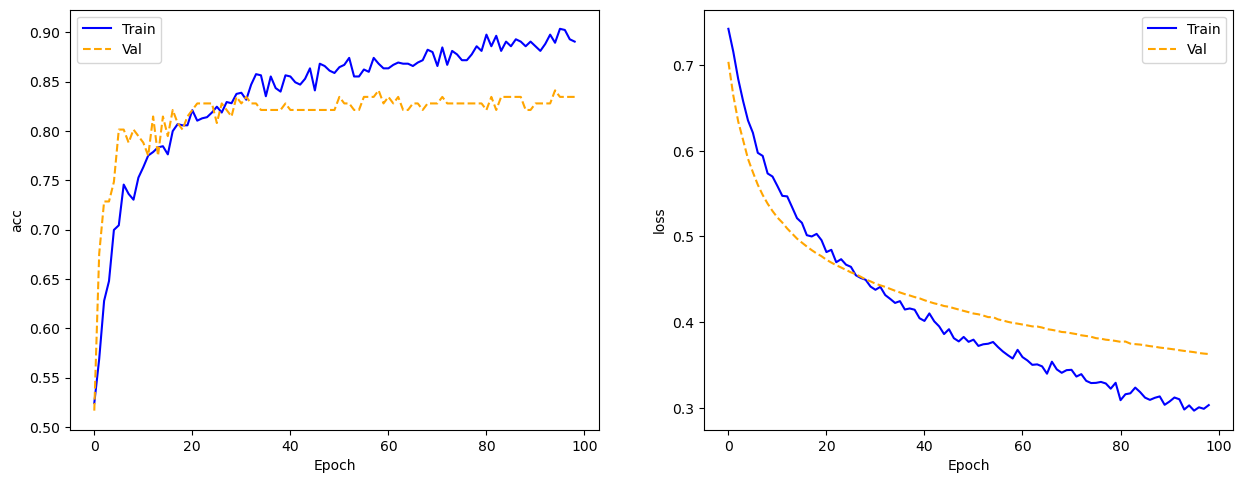

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

colors = ['blue','orange']
plt.figure(figsize=(15, 12))
metrics = ['acc', 'loss']
    
for i, metric in enumerate(metrics):
    plt.subplot(220 + 1 + i)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
                color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    #plt.show() 
    plt.savefig('temp_plot.jpeg')  
    temp_plot = Image.open('temp_plot.jpeg')
    temp_plot.save('acc_loss.jpeg')
    temp_plot.close()  
    os.remove('temp_plot.jpeg')

        


### Evaluating the Model using Test dataset
In this project we have around 900 images which is low so we splitted dataset into train and test dataset and used test dataset for validation as well as testing.

In [26]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 46ms/step - loss: 0.3991 - acc: 0.8411 - precision: 0.8188 - recall: 0.8079 - auc: 0.9021 - fp: 27.0000 - fn: 29.0000 - tp: 122.0000 - tn: 124.0000


[0.39911985397338867,
 0.8410596251487732,
 0.818791925907135,
 0.807947039604187,
 0.9020722508430481,
 27.0,
 29.0,
 122.0,
 124.0]

### Creating Classification Report and Confusion Matrix based on the prediction by the Model

In [27]:
y_test_indices = np.argmax(y_test, axis=1)

# Get the predicted class indices using model.predict and np.argmax
y_pred_indices = np.argmax(model.predict(X_test), axis=1)

class_names = ['exo_planet','non_exo_planet']

# Generate and print the classification report
print(classification_report(y_test_indices, y_pred_indices, target_names=class_names))

5/5 [==============================] - 2s 41ms/step
                precision    recall  f1-score   support

    exo_planet       0.82      0.84      0.83        70
non_exo_planet       0.86      0.84      0.85        81

      accuracy                           0.84       151
     macro avg       0.84      0.84      0.84       151
  weighted avg       0.84      0.84      0.84       151



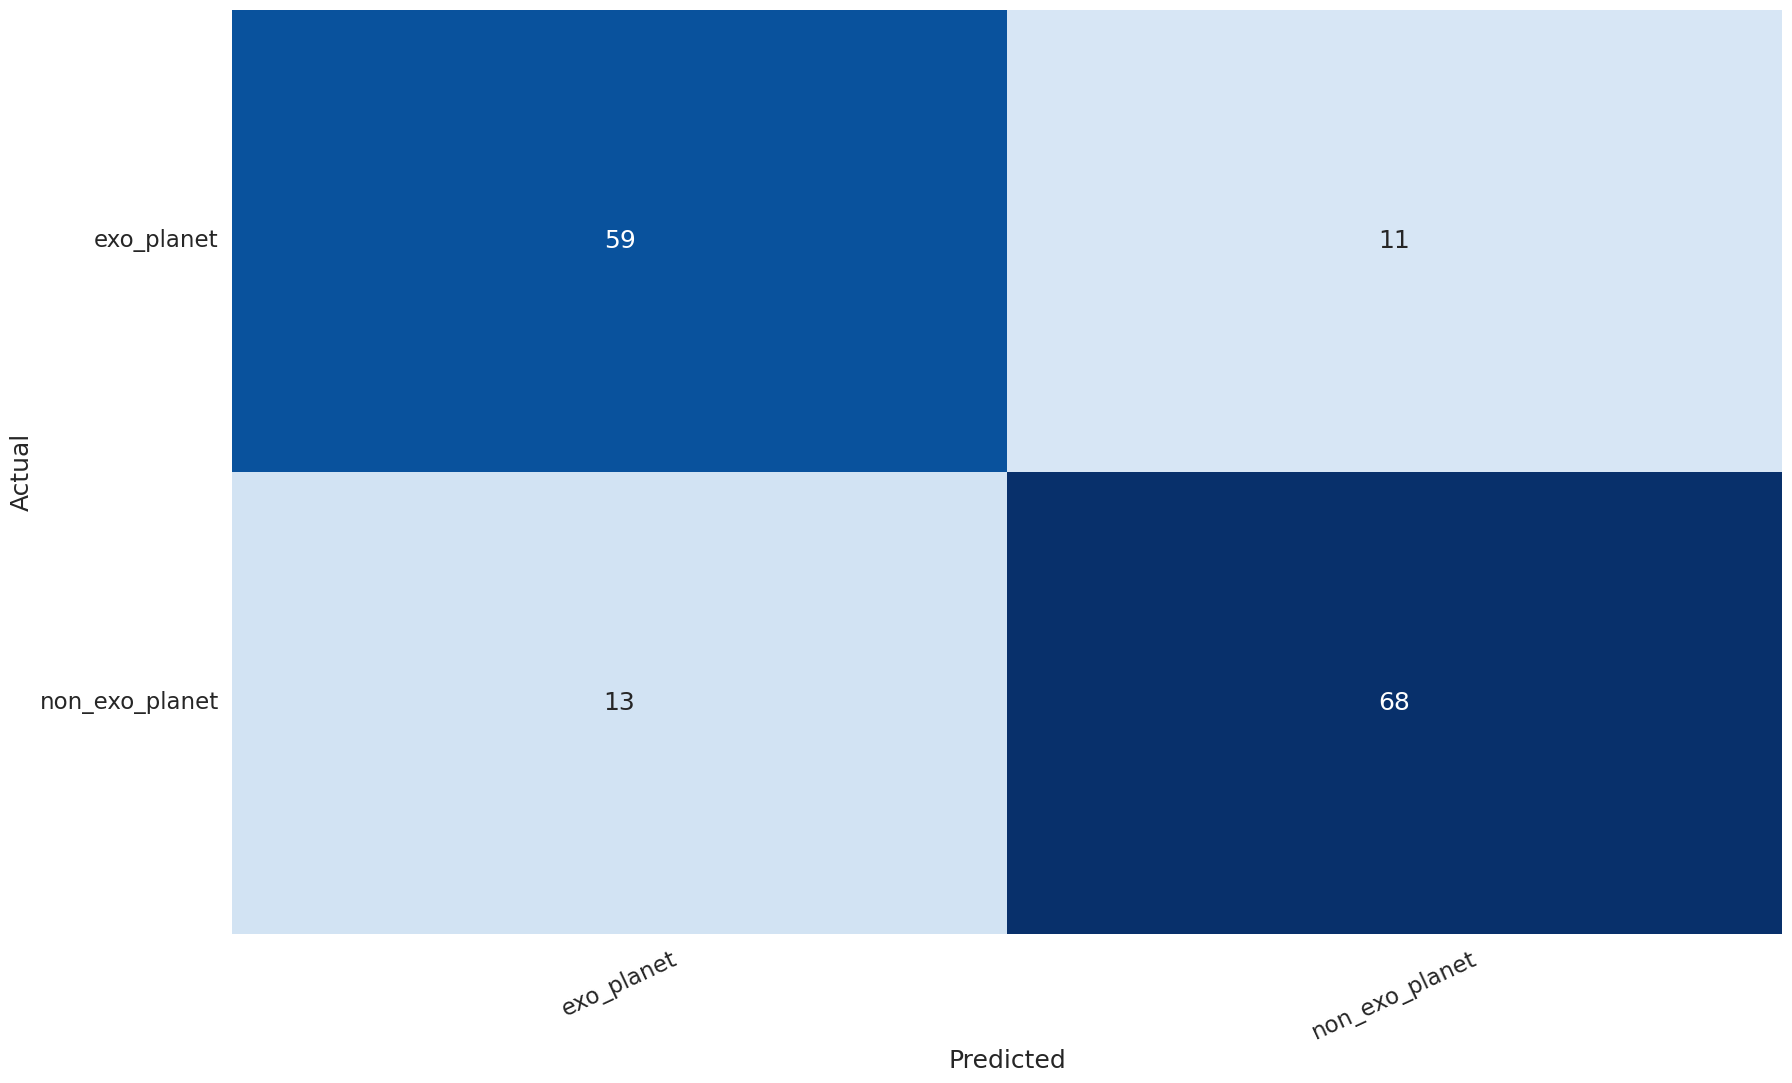

In [29]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices)

# Set the font scale
sns.set(font_scale=1.5)

# Plot the heatmap
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=25)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.title("Confusion Matrix")

# Show the plot
#plt.show()
plt.savefig('temp_plot.jpeg')  
temp_plot = Image.open('temp_plot.jpeg')
temp_plot.save('confusion_matrix.jpeg')
temp_plot.close()  
os.remove('temp_plot.jpeg')

# Fine-Tuning the Pre-trained Deep learning Model

### Unfreezing the Bottom-layers of the model and make them untrainable

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier  added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

### Fine-tuning the Deep Learning Model

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 265

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Again Compiling the Deep Learning Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['acc','Precision','Recall',
            tf.keras.metrics.AUC(multi_label=True),
             tf.keras.metrics.FalsePositives(name='fp'),
             tf.keras.metrics.FalseNegatives(name='fn'), 
             tf.keras.metrics.TruePositives(name='tp'), 
             tf.keras.metrics.TrueNegatives(name='tn')
            ]
)

In [ ]:
#len(model.trainable_variables)

### Again training the Model after Fine-Tuning

In [ ]:

fine_tune_epochs = 200
total_epochs =  200 + fine_tune_epochs

history = model.fit(X_train, y_train,batch_size =32, epochs=total_epochs,
                    initial_epoch=history.epoch[-1], callbacks=[early_stop], validation_data=(X_test,y_test))

### Evaluation of the Model after Fine-Tuning

In [ ]:
model.evaluate(X_test,y_test)

### Plotting Accuracy vs epochs and Loss vs epochs graph

In [ ]:
colors = ['blue','orange']
plt.figure(figsize=(15, 12))
metrics = ['acc', 'loss']
    
for i, metric in enumerate(metrics):
    plt.subplot(220 + 1 + i)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
                color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.savefig('temp_plot.jpeg')  
    temp_plot = Image.open('temp_plot.jpeg')
    temp_plot.save('acc_loss_1.jpeg')
    temp_plot.close()  
    os.remove('temp_plot.jpeg')

### Creating Classification Report and Confusion Matrix based on the prediction by the Model

In [ ]:
y_test_indices = np.argmax(y_test, axis=1)

# Get the predicted class indices using model.predict and np.argmax
y_pred_indices = np.argmax(model.predict(X_test), axis = 1)

class_names = ['angry','happy','sad']

# Generate and print the classification report
print(classification_report(y_test_indices, y_pred_indices, target_names=class_names))

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices)

# Set the font scale
sns.set(font_scale=1.5)

# Plot the heatmap
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(3)+.5, class_names, rotation=25)
plt.yticks(np.arange(3)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.title("Confusion Matrix")

# Show the plot
#plt.show()
plt.savefig('temp_plot.jpeg')  
temp_plot = Image.open('temp_plot.jpeg')
temp_plot.save('confusion_matrix_1.jpeg')
temp_plot.close()  
os.remove('temp_plot.jpeg')

### Plotting Receiver Operating Characteristics(ROC) Curve

In [30]:
y_pred_roc = model.predict(X_test)

5/5 [==============================] - 0s 42ms/step


KeyError: 1

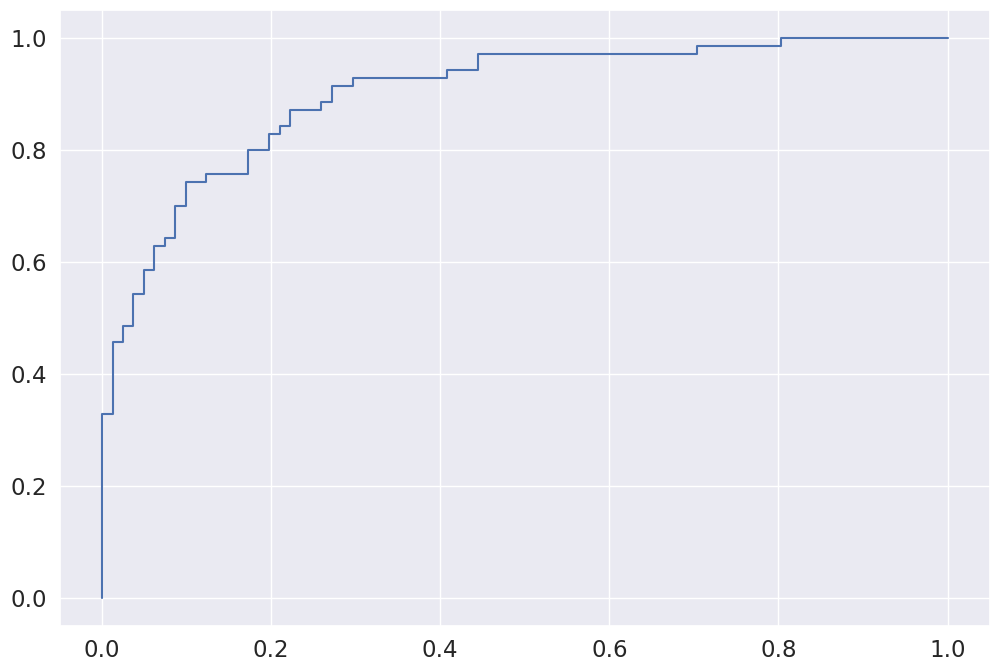

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Convert class labels to one-hot encoded format
y_test_bin = label_binarize(y_test_indices, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_roc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random Chance')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.show()
plt.savefig('temp_plot.jpeg')  
temp_plot = Image.open('temp_plot.jpeg')
temp_plot.save('roc_auc.jpeg')
temp_plot.close()  
os.remove('temp_plot.jpeg')

### Predicting the direction of penalty shot and comparing with original direction of the shot

In [ ]:
#Dictionary for mapping class_id with the direction of the penalty shot
penalty_dict_test={
    0:'angry',
    1:'happy',
    2:'sad'
}

In [ ]:
from tensorflow.keras.preprocessing import image

# Function to display images and predictions in subplots
def display_images_with_predictions(model):
    # Get the total number of datapoints
    num_datapoints = X_test.shape[0]

    # Select 9 random indices
    random_indices = np.random.choice(num_datapoints, size=15, replace=False)

    # Extract the corresponding datapoints
    selected_datapoints = X_test[random_indices]
    selected_labels = y_test[random_indices]
    # Make predictions
    predictions = model.predict(selected_datapoints)

    # Convert one-hot encoded labels to class indices
    true_labels = np.argmax(selected_labels, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Plot the selected images
    plt.figure(figsize=(40, 20))
    for i in range(len(random_indices)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(selected_datapoints[i])  # Assuming each element in X_test is an image
        plt.title(f'True: {penalty_dict_test[true_labels[i]]}\nPredicted: {penalty_dict_test[predicted_labels[i]]}',fontsize=25)
        plt.axis('off')
        #plt.show()
        plt.savefig('temp_plot.jpeg')  
        temp_plot = Image.open('temp_plot.jpeg')
        temp_plot.save('true_pred.jpeg')
        temp_plot.close()  
        os.remove('temp_plot.jpeg')

# Display images and predictions from valdata
display_images_with_predictions(model)

In [ ]:
model.save('Model_save.h5')

## Conclusion:

After training the model(InceptionV3) with fine-tuning the following metric we got:
1. Validation_accuracy: 0.9179
2. Validation_precision: 0.9179
3. Validation_recall: 0.9104
4. Validation_auc: 0.9946
5. Validation_F1_score: 0.9141